# Performance evolution of the simdjson library

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
from statsmodels.formula.api import ols
from numpy import log, mean, std

warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'result.csv')
    res['timestamp'] = pandas.to_datetime(res['timestamp'], format='%Y-%m-%d %H:%M:%S:%f')
    res['timestamp'] = res['timestamp'] - res['timestamp'].min()
    info = get_yaml(name, 'info.yaml')
    res['cluster'] = info['cluster']
    res['expfile'] = info['expfile'][0]
    installfile = info['installfile']
    installfile = get_yaml(name, installfile)
    res['version'] = installfile['version']
    return res

directory = '3/'
all_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.zip')]

df = pandas.concat([read_result(f) for f in all_files])
df.head()

,timestamp,proc_id,run_id,call_id,duration,speed,hostname,filename,cluster,expfile,version
0,00:00:00.011000,0,0,0,0.005015,1.25915,gros-2.nancy.grid5000.fr,3/nancy_2020-05-10_2472907.zip,gros,twitter10.json,v0.2.1
1,00:00:00.011000,0,0,1,0.005042,1.25244,gros-2.nancy.grid5000.fr,3/nancy_2020-05-10_2472907.zip,gros,twitter10.json,v0.2.1
2,00:00:00.011000,0,0,2,0.004256,1.48376,gros-2.nancy.grid5000.fr,3/nancy_2020-05-10_2472907.zip,gros,twitter10.json,v0.2.1
3,00:00:00.011000,0,0,3,0.004241,1.48895,gros-2.nancy.grid5000.fr,3/nancy_2020-05-10_2472907.zip,gros,twitter10.json,v0.2.1
4,00:00:00.011000,0,0,4,0.004290,1.47192,gros-2.nancy.grid5000.fr,3/nancy_2020-05-10_2472907.zip,gros,twitter10.json,v0.2.1


In [2]:
versions = {
    '3c3a4db54e1775de6e1946e66d7524f2f38aa02a': '2020-05-06 23:08:10',
    '76314280cb3f31894e107caadd5eb1650a7a6a44': '2020-04-25 11:24:41',
    '1ff22c78b3f5111b865664d278981f5537129497': '2020-04-09 14:56:54',
    'e04cbd71d097ad8f8bb3316b7fb1875568c9d13c': '2020-05-02 01:44:11',
    'ff09b6c82494af6dbe42fa3a218ed86f15dc8666': '2020-04-17 12:23:05',
    'v0.3.1': '2020-04-02 19:24:43',
    'v0.3.0': '2020-03-31 17:47:25',
    'v0.2.1': '2019-08-04 15:43:47',
    'v0.2.0': '2019-08-01 16:23:30'
}

versions = {v: pandas.to_datetime(d) for v, d in versions.items()}
df['version_date'] = 'NA'
for version, date in versions.items():
    df.loc[df['version'] == version, 'version_date'] = date

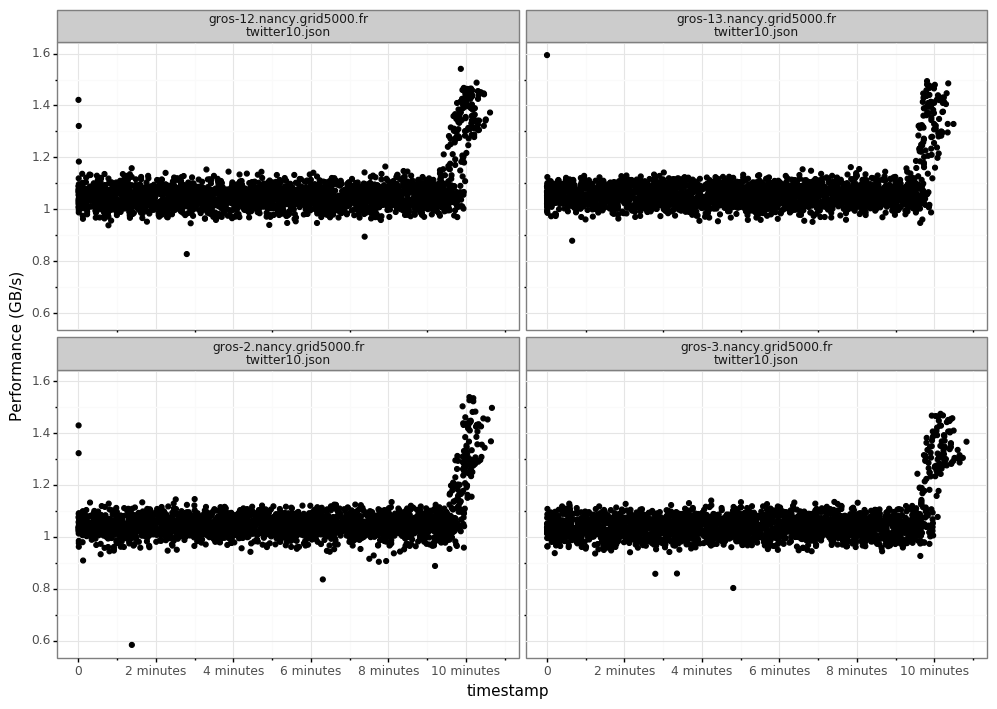

<ggplot: (-9223363299436175914)>

In [3]:
ggplot(df.sample(n=10000)) +\
    aes(x='timestamp', y='speed') +\
    geom_point() +\
    facet_wrap(['hostname', 'expfile'], nrow=2) +\
    ylab('Performance (GB/s)') +\
    labs(color='Call index') +\
    theme_bw()

In [4]:
df.run_id.max()

99

Alright, let's remove the first and last 20 runs.

In [5]:
steady_state = df[(df['run_id'] >= 20) & (df['run_id'] < df['run_id'].max()-20)]

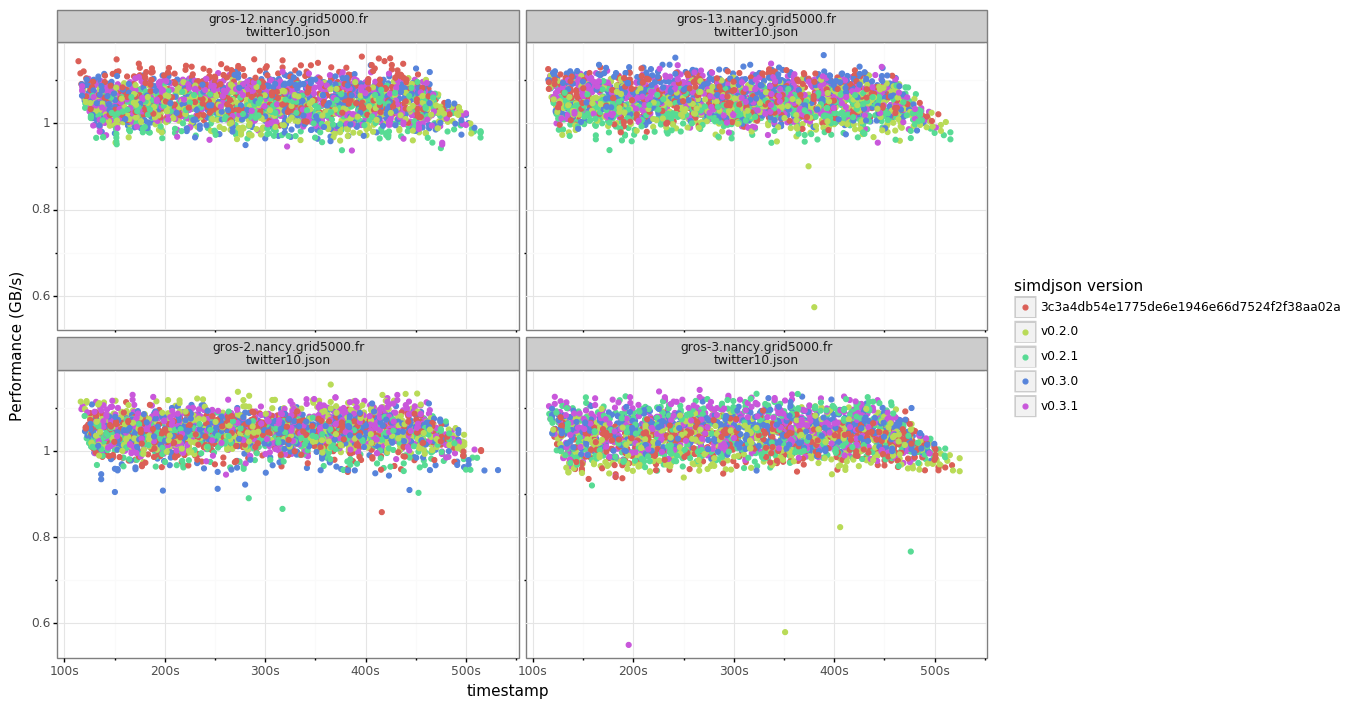

<ggplot: (-9223363299343182953)>

In [6]:
ggplot(steady_state.sample(n=10000)) +\
    aes(x='timestamp', y='speed', color='version') +\
    geom_point() +\
    facet_wrap(['hostname', 'expfile'], nrow=2) +\
    ylab('Performance (GB/s)') +\
    labs(color='simdjson version') +\
    theme_bw()

(0.303019, 1.2059)


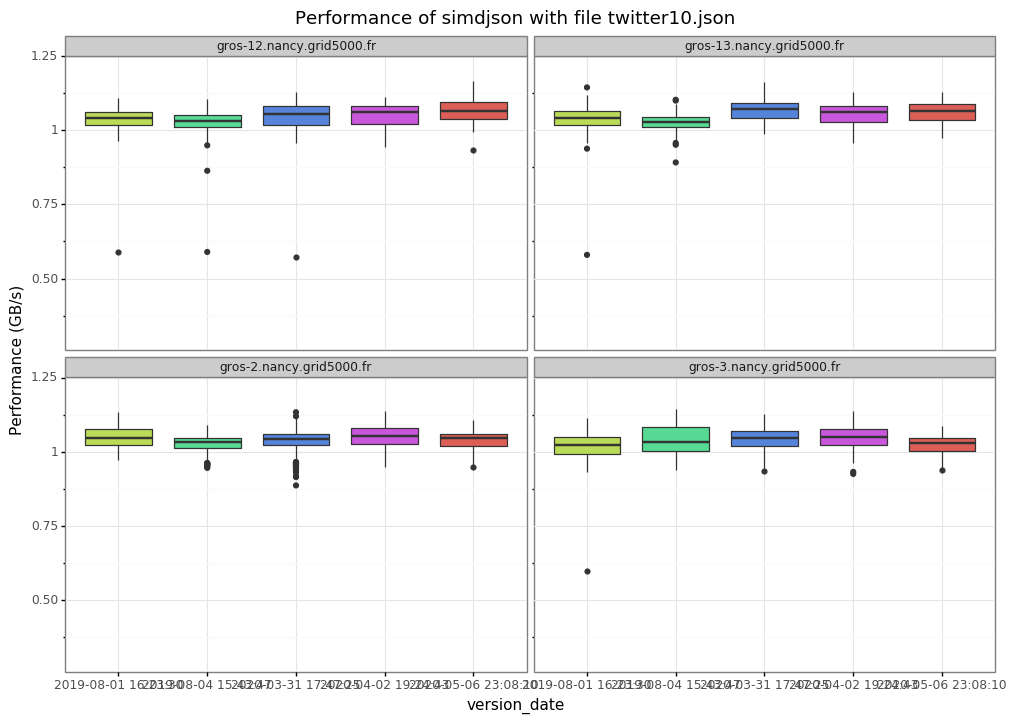

<ggplot: (-9223363299445095985)>


In [7]:
ycol = 'speed'
minmax = (steady_state[ycol].min(), steady_state[ycol].max())
print(minmax)

for cluster in df['cluster'].unique():
    for expfile in df['expfile'].unique():
        tmp = steady_state[(steady_state['cluster'] == cluster) & (steady_state['expfile'] == expfile)].sample(n=10000)
        plot = ggplot(tmp) +\
            aes(x='version_date', y=ycol, fill='version') +\
            geom_boxplot() +\
            facet_wrap('hostname', nrow=2) +\
            theme_bw() +\
            expand_limits(y=minmax) +\
            ylab('Performance (GB/s)') +\
            labs(fill='simdjson version') +\
            theme(legend_position='none') +\
            ggtitle(f'Performance of simdjson with file {expfile}')
        print(plot)